In [1]:

# Import Libraries
import pandas as pd
import numpy as np
import os
from dask import dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta

def ConvertDate(string):
    date = pd.to_datetime(string, format='%Y-%m-%d')
    return date

def displayDataFrame(df):
    with pd.option_context('display.max_columns', None):
        display(df)
    
def SummaryDataFrame(df, ConditionName):
    print('-----------------------------')
    print('\033[1m' + ConditionName.upper() + '\033[0m')
    print('\033[1m Columns: \033[0m')
    print(df.columns)
    print('\033[1m Size of dataset: \033[0m', df.shape)
    displayDataFrame(df.head(2))


In [2]:

# Open datasets with flagged errors

def OpenFile(dataset):
    print('Reading', dataset, 'dataset...')
    Path = r"O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Data\1_Processed"
    FileName = dataset + '_SpellLevel_FeatureEngineered.csv'
    FilePath = os.path.join(Path, FileName)
    df_dataset = pd.read_csv(FilePath)
    
    return df_dataset

df_Diabetes_ini = OpenFile('Diabetes')
SummaryDataFrame(df_Diabetes_ini, 'Diabetes')

# df_Autism_ini = OpenFile('Autism')
# SummaryDataFrame(df_Autism_ini, 'Autism')

# df_Dementia_ini = OpenFile('Dementia')
# SummaryDataFrame(df_Dementia_ini, 'Dementia')


Reading Diabetes dataset...
-----------------------------
DIABETES
 Columns: 
Index(['Unnamed: 0', 'P_Spell_ID', 'HESID', 'LSOA_2011_Code', 'Admission_date',
       'Discharge_date', 'EPIstart', 'EPIend', 'diagnosis_group', 'Spell_Los',
       'sex', 'age_of_patient', 'Ethnicity', 'IMD_Score', 'IMD_Decile',
       'HFRS_Score', 'HFRS_Band', 'ProvCode', 'Main_Specialty_Description',
       'POD', 'MORT', 'Read30', 'Read90', 'TimeDiff_FirstSpell', 'Region',
       'Missing_Age', 'Missing_IMD_Score', 'POD_Elective', 'POD_Emergency',
       'Missing_POD', 'ProvCode_PrivateProv', 'Spell_Los_0',
       'FirstSpell_P_Spell_ID', 'FirstSpell_Admission_date',
       'FirstSpell_Discharge_date', 'FirstSpell_ProvCode', 'FirstSpell_POD',
       'FirstSpell_Main_Specialty_Description', 'FirstSpell_Region',
       'FirstSpell_ProvCode_PrivateProv', 'Change_ProvCode', 'Change_Region',
       'Change_Main_Specialty_Description', 'Change_ProvCode_Type',
       'SpellLevel_ICD10', 'SpellLevel_ICD10_Diabe

,Unnamed: 0,P_Spell_ID,HESID,LSOA_2011_Code,Admission_date,Discharge_date,EPIstart,EPIend,diagnosis_group,Spell_Los,sex,age_of_patient,Ethnicity,IMD_Score,IMD_Decile,HFRS_Score,HFRS_Band,ProvCode,Main_Specialty_Description,POD,MORT,Read30,Read90,TimeDiff_FirstSpell,Region,Missing_Age,Missing_IMD_Score,POD_Elective,POD_Emergency,Missing_POD,ProvCode_PrivateProv,Spell_Los_0,FirstSpell_P_Spell_ID,FirstSpell_Admission_date,FirstSpell_Discharge_date,FirstSpell_ProvCode,FirstSpell_POD,FirstSpell_Main_Specialty_Description,FirstSpell_Region,FirstSpell_ProvCode_PrivateProv,Change_ProvCode,Change_Region,Change_Main_Specialty_Description,Change_ProvCode_Type,SpellLevel_ICD10,SpellLevel_ICD10_Diabetes,SpellLevel_ICD10_DiabetesTypeII,SpellLevel_FirstDiagnosis,SubsequentSpell,SpellLevel_Error_Diabetes
0,0,941,0005MWSQ5R4HJ9V,E01030750,2016-09-29,2016-09-29,2016-09-29,2016-09-29,I7020~M314~E115~I792~I340~I071~I252~Z955~E782~...,0,Female,38,other ethnic groups,19.873,5.0,0.0,None,RYJ,general surgery,DC,0,NaN,NaN,0.0,London,0,0,1,0,0,0,1,941.0,2016-09-29,2016-09-29,RYJ,DC,general surgery,London,0,0,0,0,0,I7020~M314~E115~I792~I340~I071~I252~Z955~E782~...,1,1,1,0,0
1,1,942,0005MWSQ5R4HJ9V,E01030750,2016-10-13,2016-10-13,2016-10-13,2016-10-13,M314~I7020~E115~I792~I340~I071~I252~Z955~E782~...,0,Female,38,other ethnic groups,19.873,5.0,0.0,None,RYJ,general surgery,DC,0,NaN,NaN,14.0,London,0,0,1,0,0,0,1,941.0,2016-09-29,2016-09-29,RYJ,DC,general surgery,London,0,0,0,0,0,M314~I7020~E115~I792~I340~I071~I252~Z955~E782~...,1,1,0,1,0


In [7]:

# Process and Encode features
# --------------------------------------------------
def ProcessAndEncode(df_ini, ConditionName):
    df = df_ini.copy()
    ErrorName = 'SpellLevel_Error_'+ConditionName

    # Only keep readmissions (SpellLevel_TimeDiff>0)
    Filter_SubsequentSpell = (df.loc[:, 'SubsequentSpell']==1)
    df = df.loc[Filter_SubsequentSpell, :].drop(columns=['SubsequentSpell'])
    
    # Select Features
    ColumnList = ['sex', 'age_of_patient', 'Ethnicity',
                   'diagnosis_group',
                   'ProvCode', 'FirstSpell_ProvCode', 
                   'Main_Specialty_Description',
                   'Spell_Los', 'Spell_Los_0', 'MORT', 'Read30', 'Read90',
                   'POD_Emergency', # POD_Elective
                   'FirstSpell_ProvCode_PrivateProv', 'ProvCode_PrivateProv',
                   'Change_ProvCode', 'Change_ProvCode_Type', 'Change_Region', 'Change_Main_Specialty_Description',
                   'Missing_Age', 'Missing_IMD_Score', 'Missing_POD',
                   'HFRS_Score', 'IMD_Score',
                   'TimeDiff_FirstSpell',
                    ErrorName]

    for col in ColumnList:
        if not(col in df.columns):
            print(col)

    df = df.loc[:, ColumnList]
    
    # Encoding Read30 and Read90
    Filter_Read30 = df.loc[:, 'Read30']=='Y'
    df.loc[:, 'Read30'] = np.where(Filter_Read30, 1, 0)
    Filter_Read90 = df.loc[:, 'Read90']=='Y'
    df.loc[:, 'Read90'] = np.where(Filter_Read90, 1, 0)
    
    # Correct missing age
#     Filter_NotMissingAge = df.loc[:, 'age_of_patient']!=999
#     MeanAge = df.loc[Filter_NotMissingAge, 'age_of_patient'].median()
#     df.loc[~Filter_NotMissingAge, 'age_of_patient'] = MeanAge

    # Set dtypes
    Features_Int = ['TimeDiff_FirstSpell', 'age_of_patient'] # 'Read3Years_SinceFirst', 'MORT3Years_SinceFirst', 'NumberErrors_3YearsSinceFirst']
    d_FeaturesInt = {}
    for feature_int in Features_Int:
        d_FeaturesInt[feature_int]=int
    df = df.astype(d_FeaturesInt)
    
    # One-hot encoding
    ColumnNames = ['sex', 'Ethnicity', 'Region']
    df_Encoded = df
    for col in ColumnNames:
        if col in df_Encoded.columns:
            df_Encoded = pd.get_dummies(df_Encoded, prefix=col+'_', columns=[col], drop_first=True)
    FeatureList = list(df_Encoded.columns)
    FeatureList_Ordered = [x for x in FeatureList if x!='SpellLevel_Error_'+ConditionName] + ['SpellLevel_Error_'+ConditionName]
    df_Encoded = df_Encoded.loc[:, FeatureList_Ordered]
    
    # Region: Non-NHS provider
#     Filter_NHS = df_Encoded.loc[:, 'ProvCode'].str.startswith('R')
#     df_Encoded.loc[:, 'ProvCode_PrivateProv'] = np.where(Filter_NHS, 0, 1)
#     Filter_NHSFirst = df_Encoded.loc[:, 'FirstSpell_ProvCode'].str.startswith('R')
#     df_Encoded.loc[:, 'FirstSpell_ProvCode_PrivateProv'] = np.where(Filter_NHSFirst, 0, 1)
        
    # SPECIFIC TO DEMENTIA
    if ConditionName=='Dementia':
        # Main specialty
        CommonSpecialties_List = ['geriatric medicine', 'general medicine']
        CommonSpecialties_String = '|'.join(CommonSpecialties_List)
        Filter_CommonSpecialties = df_Encoded.loc[:, 'Main_Specialty_Description'].str.contains(CommonSpecialties_String)
        df_Encoded.loc[:, 'Main_Specialty_GeriatricGeneral'] = np.where(Filter_CommonSpecialties, 1, 0)
        # Parkinson G20
        df_Encoded.loc[:, 'SpellLevel_ICD10_Parkinson'] = df_ini.loc[:, 'SpellLevel_ICD10_Parkinson']
        # Remove <40 year-old patients
        Filter_Age = df_Encoded.loc[:, 'age_of_patient']>=40
        df_Encoded = df_Encoded.loc[Filter_Age, :]
        
    # SPECIFIC TO AUTISM
    elif ConditionName=='Autism':
        # Main specialty
        CommonSpecialties_List = ['paediatrics', 'general medicine']
        CommonSpecialties_String = '|'.join(CommonSpecialties_List)
        Filter_CommonSpecialties = df_Encoded.loc[:, 'Main_Specialty_Description'].str.contains(CommonSpecialties_String)
        df_Encoded.loc[:, 'Main_Specialty_PaediatricsGeneral'] = np.where(Filter_CommonSpecialties, 1, 0)
        # Learning Disabilities
#         Codes_LearningDisabilities = ['F7' + i + x for i in ['0', '1', '2', '3', '8', '9'] for x in ['0', '1', '8', '9']]
#         Codes_LearningDisabilities = Codes_LearningDisabilities + ['F8' + i + x for i in ['0', '1'] for x in ['0', '1', '2', '3', '8', '9']]
#         Codes_LearningDisabilities = Codes_LearningDisabilities + ['F82', 'F83'] + ['F842', 'F844', 'F848', 'F849', 'F88', 'F89']
        Codes_LearningDisabilities = ['F7' + i for i in ['0', '1', '2', '3', '8', '9']]
        Codes_LearningDisabilities_str = '|'.join(Codes_LearningDisabilities)
        Filter_LearningDisabilities = df_Encoded.loc[:, 'diagnosis_group'].str.contains(Codes_LearningDisabilities_str)
        df_Encoded.loc[:, 'SpellLevel_ICD10_LearningDisabilities'] = np.where(Filter_LearningDisabilities, 1, 0)
    # SPECIFIC TO DIABETES
    elif ConditionName=='Diabetes':
        # Main specialty
        CommonSpecialties_List = ['general medicine', 'general surgery']
        CommonSpecialties_String = '|'.join(CommonSpecialties_List)
        Filter_CommonSpecialties = df_Encoded.loc[:, 'Main_Specialty_Description'].str.contains(CommonSpecialties_String)
        df_Encoded.loc[:, 'Main_Specialty_GeneralMedecineSurgery'] = np.where(Filter_CommonSpecialties, 1, 0)
        # Remove <18 year-old patients
        Filter_Age = df_Encoded.loc[:, 'age_of_patient']>=18
        df_Encoded = df_Encoded.loc[Filter_Age, :]
        
    # Drop final columns
    ColumnsDrop = ['ProvCode', 'FirstSpell_ProvCode', 'Main_Specialty_Description',
                   'Read90', 'Ethnicity__not known',
                   'diagnosis_group']
    ColumnsDrop_in = [x for x in ColumnsDrop if x in df_Encoded.columns]
    df_Encoded = df_Encoded.drop(columns=ColumnsDrop_in)
    

    return df_Encoded
# --------------------------------------------------

df_Diabetes_Encoded = ProcessAndEncode(df_Diabetes_ini, "Diabetes")
SummaryDataFrame(df_Diabetes_Encoded, 'Diabetes')

# df_Dementia_Encoded = ProcessAndEncode(df_Dementia_ini, "Dementia")
# SummaryDataFrame(df_Dementia_Encoded, 'Dementia')

# df_Autism_Encoded = ProcessAndEncode(df_Autism_ini, "Autism")
# SummaryDataFrame(df_Autism_Encoded, 'Autism')


-----------------------------
DIABETES
 Columns: 
Index(['age_of_patient', 'Spell_Los', 'Spell_Los_0', 'MORT', 'Read30',
       'POD_Emergency', 'FirstSpell_ProvCode_PrivateProv',
       'ProvCode_PrivateProv', 'Change_ProvCode', 'Change_ProvCode_Type',
       'Change_Region', 'Change_Main_Specialty_Description', 'Missing_Age',
       'Missing_IMD_Score', 'Missing_POD', 'HFRS_Score', 'IMD_Score',
       'TimeDiff_FirstSpell', 'sex__Male', 'Ethnicity__black or black british',
       'Ethnicity__mixed', 'Ethnicity__other ethnic groups',
       'Ethnicity__white', 'SpellLevel_Error_Diabetes',
       'Main_Specialty_GeneralMedecineSurgery'],
      dtype='object')
 Size of dataset:  (913300, 25)


,age_of_patient,Spell_Los,Spell_Los_0,MORT,Read30,POD_Emergency,FirstSpell_ProvCode_PrivateProv,ProvCode_PrivateProv,Change_ProvCode,Change_ProvCode_Type,Change_Region,Change_Main_Specialty_Description,Missing_Age,Missing_IMD_Score,Missing_POD,HFRS_Score,IMD_Score,TimeDiff_FirstSpell,sex__Male,Ethnicity__black or black british,Ethnicity__mixed,Ethnicity__other ethnic groups,Ethnicity__white,SpellLevel_Error_Diabetes,Main_Specialty_GeneralMedecineSurgery
1,38,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,19.873,14,0,0,0,1,0,0,1
2,39,7,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,19.873,111,0,0,0,0,1,0,1


In [10]:

# Visualise correlations between features
def CorrelatedFeatures(df_ini, Threshold):
    df = df_ini.copy()
    M = df.corr().abs()
    df_corr = M.stack().reset_index().rename(columns={'level_0':'Feature_1',
                                                      'level_1':'Feature_2',
                                                      0:'Correlation'})
    Filter_Threshold = (df_corr.loc[:, 'Correlation']<1) & (df_corr.loc[:, 'Correlation']>=Threshold)
    df_corr = df_corr.loc[Filter_Threshold, :]
    if df_corr.shape[0]==0:
        print('No highly-correlated pairs.')
    else:
        displayDataFrame(df_corr)

Threshold = 0.7
CorrelatedFeatures(df_Diabetes_Encoded, Threshold)
print('Removing correlated features...')
ColumnList = ['Spell_Los_0', 'Missing_Age', 'ProvCode_PrivateProv']
df_Diabetes_Encoded = df_Diabetes_Encoded.drop(columns=ColumnList)
CorrelatedFeatures(df_Diabetes_Encoded, Threshold)


,Feature_1,Feature_2,Correlation
12,age_of_patient,Missing_Age,0.815206
55,Spell_Los_0,POD_Emergency,0.790488
127,POD_Emergency,Spell_Los_0,0.790488
184,ProvCode_PrivateProv,Change_ProvCode_Type,0.817126
232,Change_ProvCode_Type,ProvCode_PrivateProv,0.817126
300,Missing_Age,age_of_patient,0.815206


Removing correlated features...
No highly-correlated pairs.


# Implement Classifier

In [11]:

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, accuracy_score, make_scorer
from sklearn.inspection import permutation_importance


In [12]:

# Split dataset
# --------------------------------------------------
def TrainTestSplit(df_ini, ConditionName):
    df = df_ini
    y_ini = df.loc[:, 'SpellLevel_Error_'+ConditionName]
    X_ini = df.drop(columns=['SpellLevel_Error_'+ConditionName])
    
    # Add random variables: binary and continuous
    rng = np.random.RandomState(seed=42)
    X_ini["RANDOM_cat"] = rng.randint(2, size=X_ini.shape[0])
    X_ini["RANDOM_num"] = rng.randn(X_ini.shape[0])
    
    # Test: dropping column with feature importance <= 1% max
#     ColumnsImportant = ['SpellLevel_ICD10_Parkinson',
#                  'POD_Emergency',
#                  'age_of_patient',
#                  'Main_Specialty_GeriatricGeneral',
#                  'TimeDiff_FirstSpell',
#                  'IMD_Score',
#                  'Change_ProvCode',
#                  'sex__Male',
#                  'Ethnicity__white',
#                  'Read30',
#                  'Change_Main_Specialty_Description',
#                  'Spell_Los_0']
#     X_ini = X_ini.loc[:, ColumnsImportant]
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_ini, y_ini, test_size=0.15, stratify=y_ini, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.15/0.85)
    
    print("\n \033[1m", ConditionName.upper(),'\033[0m :')
    print('Size of training set:', X_train.shape, 'corresponding to %0.2f' % (100*X_train.shape[0]/X_ini.shape[0]), '%')
    print('Size of validation set:', X_val.shape, 'corresponding to %0.2f' % (100*X_val.shape[0]/X_ini.shape[0]), '%')
    print('Size of test set:', X_test.shape, 'corresponding to %0.2f' % (100*X_test.shape[0]/X_ini.shape[0]), '%')
    print('List of features:', X_train.columns)
    
    return X_ini, y_ini, X_train, X_val, X_test, y_train, y_val, y_test
# --------------------------------------------------

X_ini_Diabetes, y_ini_Diabetes, X_train_Diabetes, X_val_Diabetes, X_test_Diabetes, y_train_Diabetes, y_val_Diabetes, y_test_Diabetes = TrainTestSplit(df_Diabetes_Encoded, "Diabetes")
# X_ini_Dementia, y_ini_Dementia, X_train_Dementia, X_val_Dementia, X_test_Dementia, y_train_Dementia, y_val_Dementia, y_test_Dementia = TrainTestSplit(df_Dementia_Encoded, "Dementia")
# X_ini_Autism, y_ini_Autism, X_train_Autism, X_val_Autism, X_test_Autism, y_train_Autism, y_val_Autism, y_test_Autism = TrainTestSplit(df_Autism_Encoded, "Autism")



  DIABETES  :
Size of training set: (639310, 23) corresponding to 70.00 %
Size of validation set: (136995, 23) corresponding to 15.00 %
Size of test set: (136995, 23) corresponding to 15.00 %
List of features: Index(['age_of_patient', 'Spell_Los', 'MORT', 'Read30', 'POD_Emergency',
       'FirstSpell_ProvCode_PrivateProv', 'Change_ProvCode',
       'Change_ProvCode_Type', 'Change_Region',
       'Change_Main_Specialty_Description', 'Missing_IMD_Score', 'Missing_POD',
       'HFRS_Score', 'IMD_Score', 'TimeDiff_FirstSpell', 'sex__Male',
       'Ethnicity__black or black british', 'Ethnicity__mixed',
       'Ethnicity__other ethnic groups', 'Ethnicity__white',
       'Main_Specialty_GeneralMedecineSurgery', 'RANDOM_cat', 'RANDOM_num'],
      dtype='object')


## Tuning classifier

In [13]:

# Define classifier to optimise
clf_RF = RandomForestClassifier()

def OptimisationRF(clf, X_val, y_val, random_grid, ConditionName):
    print('Optimising \033[1m', ConditionName.upper(), '\033[0m classifier...')

    # Define CV
    CV = StratifiedKFold(n_splits=5, random_state=None)
    
    # Define metrics of interest: AUROC - AUPR Curve
    metric_ROC_auc = 'roc_auc'

    def metric_PR_auc(y_true, probas_pred):
        p, r, _ = precision_recall_curve(y_true, probas_pred)
        return auc(r, p)
    metric_PR_auc = make_scorer(metric_PR_auc, needs_proba=True)
    
    Scoring = metric_PR_auc

    # Random search training
    clf_RF_random = RandomizedSearchCV(estimator=clf_RF,
                                        param_distributions=random_grid,
                                        n_iter=20,
                                        cv=CV,
                                        verbose=2,
                                        random_state=42,
                                        n_jobs=-1,
                                        scoring='roc_auc')
    
    clf_RF_random.fit(X_val, y_val)
    
    print(ConditionName.upper(), ': DONE')
    print(clf_RF_random.best_params_)
    
    return clf_RF_random
    
# Initialise classifiers
clf_RF_Dementia = RandomForestClassifier()
clf_RF_Autism = RandomForestClassifier()
clf_RF_Diabetes = RandomForestClassifier()

# Construct grid of parameters
n_estimators = [int(x) for x in np.linspace(100, 300, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(60, 100, 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

random_grid_long = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap,
               'class_weight':class_weight}

random_grid_short = {'n_estimators':n_estimators,
                     'max_features':max_features,
                     'max_depth':max_depth}

# Optimise classifiers on validation sets
clf_RF_Diabetes_gridSearch = OptimisationRF(clf_RF_Diabetes, X_val_Diabetes, y_val_Diabetes, random_grid_long, 'Diabetes')
# clf_RF_Dementia_gridSearch = OptimisationRF(clf_RF_Dementia, X_val_Dementia, y_val_Dementia, random_grid_long, 'Dementia')
# clf_RF_Autism_gridSearch = OptimisationRF(clf_RF_Autism, X_val_Autism, y_val_Autism, random_grid_long, 'Autism')


Optimising  DIABETES  classifier...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [45]:


# Define optimised classifier
clf_RF_Diabetes_Optimised = RandomForestClassifier(n_estimators=246,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_depth=83,
                                max_features='sqrt',
                                bootstrap=False,
                                class_weight='balanced_subsample')


In [46]:

print('Training on DIABETES dataset...')
clf_RF_Diabetes = clf_RF_Diabetes_Optimised.fit(X_train_Diabetes, y_train_Diabetes)
# print('Training on DEMENTIA dataset...')
# clf_RF_Dementia_Optimised = clf_RF_Dementia_Optimised.fit(X_train_Dementia, y_train_Dementia)
# print('Training on AUTISM dataset...')
# clf_RF_Autism_Optimised = clf_RF_Autism_Optimised.fit(X_train_Autism, y_train_Autism)
print('Training: \033[1m DONE \033[0m')


Training on DIABETES dataset...
Training:  DONE 



 +  DIABETES 
ROC Score: 0.96
Accuracy: 0.94


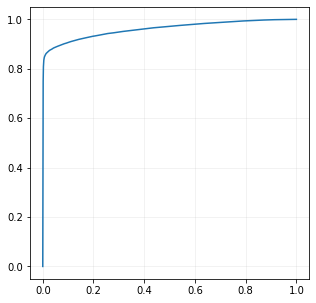

In [47]:

# Calculate ROC score and plot ROC characteristic
# --------------------------------------------------
def fit_ROC(clf_RF, X_test, y_test, ConditionName):
    y_proba = clf_RF.predict_proba(X_test)[:, 1]
    ROC_Score = roc_auc_score(y_test, y_proba)
    print('\n + \033[1m', ConditionName.upper(), '\033[0m')
    print('ROC Score: %0.2f' % ROC_Score)
    print('Accuracy: %0.2f' % accuracy_score(clf_RF.predict(X_test), y_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.grid('on', alpha=0.2)
# --------------------------------------------------

## Feature importance: Permutation using sklearn
fit_ROC(clf_RF_Diabetes_Optimised, X_test_Diabetes, y_test_Diabetes, 'Diabetes')
# fit_ROC(clf_RF_Dementia_Optimised, X_test_Dementia, y_test_Dementia, 'Dementia')
# fit_ROC(clf_RF_Autism_Optimised, X_test_Autism, y_test_Autism, 'Autism')


## Feature importance: Permutation using sklearn

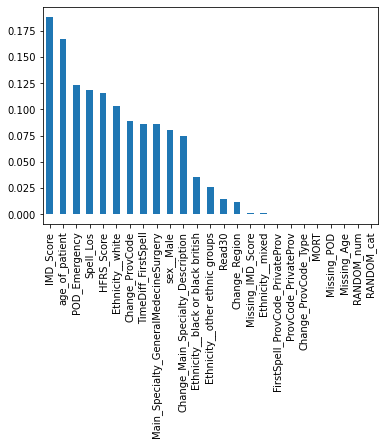

In [48]:

def FeatureImportance_sklearn(clf, X, y):
    I_Dementia = permutation_importance(clf, X, y)
    Features = X.columns
    FeatureImportance_Series = pd.Series(I_Dementia['importances_mean'], index=Features).sort_values(ascending=False)
    
    FeatureImportance_Series.plot.bar()
    return FeatureImportance_Series

FeatureImportance_sklearn_Diabetes = FeatureImportance_sklearn(clf_RF_Diabetes_Optimised, X_test_Diabetes, y_test_Diabetes)


In [51]:

FeatureImportance_sklearn_Diabetes.iloc[0:15]


IMD_Score                                0.188557
age_of_patient                           0.166967
POD_Emergency                            0.122946
Spell_Los                                0.118172
HFRS_Score                               0.115908
Ethnicity__white                         0.102986
Change_ProvCode                          0.088812
TimeDiff_FirstSpell                      0.085837
Main_Specialty_GeneralMedecineSurgery    0.085667
sex__Male                                0.080165
Change_Main_Specialty_Description        0.074623
Ethnicity__black or black british        0.035512
Ethnicity__other ethnic groups           0.025766
Read30                                   0.014370
Change_Region                            0.012095
dtype: float64

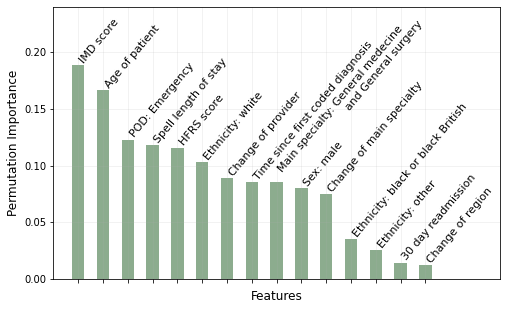

In [53]:

fig, ax = plt.subplots(figsize=(8,5))
df_FeatureImportance = pd.DataFrame({'Feature':FeatureImportance_sklearn_Diabetes.index,
                                     'Importance':FeatureImportance_sklearn_Diabetes.values})

FeatureLabels_New = ["IMD score",
                     "Age of patient",
                     "POD: Emergency",
                     "Spell length of stay",
                     "HFRS score",
                     "Ethnicity: white",
                     "Change of provider",
                     "Time since first coded diagnosis",
                     "Main specialty: General medecine \n                          and General surgery",
                     "Sex: male",
                     "Change of main specialty",
                     "Ethnicity: black or black British",
                     "Ethnicity: other",
                     "30 day readmission",
                     "Change of region"]
# FeatureLabels = FeatureLabels_New + list(df_FeatureImportance.loc[:, 'Feature'].values)[len(FeatureLabels_New):]
FeatureLabels = FeatureLabels_New

for index, value in enumerate(FeatureLabels):
    plt.text(index, 0.002+df_FeatureImportance.loc[index, 'Importance'], str(value),
             rotation='50', weight='normal', size=11,
             zorder=2) #, color=ColorText
    
Color1 = (26/255, 90/255, 30/255)
FeatureImportance_sklearn_Diabetes[0:len(FeatureLabels)].plot.bar(color=Color1, alpha=0.5);

plt.grid('on', alpha=0.2)
plt.ylim(0, 0.24)
plt.xlim(-1, 17)
ax.set_xticklabels([]);
plt.xlabel('Features', size=12);
plt.ylabel('Permutation Importance', size=12);
# plt.title("Errors related Dementia: Important Features", size=14, fontweight='bold');

SaveFig = False
if SaveFig:
    plt.savefig(r'O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Figures\Diabetes_PermutationImportance_21.12.06.png',
               bbox_inches='tight', format='png', dpi=300)


# Look at patients and trusts with many 0-LOS spells


In [121]:

# Merge OCPS column: reading orginal file
def OpenFile(dataset):
    print('Reading', dataset, 'dataset...')
    Path = r"O:\GIRFT DiRAC\FlavienHardy\1_DataConsistency\Data\0_Raw\21.11"
    FileName = 'DM Combined all 16-11-21.csv'
    FilePath = os.path.join(Path, FileName)
    df_dataset = pd.read_csv(FilePath)
    
    return df_dataset

df_Diabetes_OriginalFile = OpenFile('ORIGINAL DIABETES')
SummaryDataFrame(df_Diabetes_OriginalFile, 'Original Diabetes')


Reading ORIGINAL DIABETES dataset...


C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


-----------------------------
ORIGINAL DIABETES
 Columns: 
Index(['Category', 'Ethnicity_Description', 'P_Spell_ID1', 'Right_Epikey',
       'procedure_group', 'Right_sex', 'EPIstart', 'EPIend', 'HESID1',
       'epiorder', 'Right_ProvCode', 'Sitecode', 'LSOA_2011_Code',
       'main_specialty_code', 'Main_Specialty_Description', 'age_of_patient',
       'diagnosis_group', 'Right_POD', 'MORT', 'Right_FinY', 'Read30',
       'Read90', 'Admission_date1', 'Discharge_date1', 'Spell_Los',
       'HFRS_Score', 'HFRS_Band'],
      dtype='object')
 Size of dataset:  (1500839, 27)


,Category,Ethnicity_Description,P_Spell_ID1,Right_Epikey,procedure_group,Right_sex,EPIstart,EPIend,HESID1,epiorder,Right_ProvCode,Sitecode,LSOA_2011_Code,main_specialty_code,Main_Specialty_Description,age_of_patient,diagnosis_group,Right_POD,MORT,Right_FinY,Read30,Read90,Admission_date1,Discharge_date1,Spell_Los,HFRS_Score,HFRS_Band
0,White,British,100000833,5.016141e+11,U051~Y981~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,Female,2013-04-06,2013-04-09,FUAIUFCSIVOAEJ9,1,RA4,RA400,E01029075,300,General medicine,75,J189~E119~N189~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,EM,0,2013/14,N,Y,2013-04-06,2013-04-09,3,61.0,Severe
1,White,British,100000834,5.016140e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,2013-05-13,2013-05-14,FUAIUFCSIVOAEJ9,1,RA4,RA400,E01029075,300,General medicine,75,J189~E119~J459~N189~Z895~-1~-1~-1~-1~-1~-1~-1~...,EM,0,2013/14,N,Y,2013-05-13,2013-05-17,4,61.0,Severe


In [138]:

df = df_Diabetes_ini.copy()
Filter_0LOS = df.loc[:, 'Spell_Los']==0
df_0LOS = df.loc[Filter_0LOS, :]

# Find trusts with many 0-LOS spells
df_0LOS_Trusts = df_0LOS.groupby(by=['ProvCode'])['P_Spell_ID'].agg('count').reset_index().rename(columns={'P_Spell_ID':'Number_0LosSpells'})
df_0LOS_Trusts = df_0LOS_Trusts.sort_values(by=['Number_0LosSpells'], ascending=False)

List_Trusts_High0LOS = list(df_0LOS_Trusts.loc[:, 'ProvCode'].head(15).values)
display(df_0LOS_Trusts.head(10))

# Merge OPCS feature
ColumnList = ['P_Spell_ID1', 'procedure_group']
df_OPCS = df_Diabetes_OriginalFile.loc[:, ColumnList].rename(columns={'P_Spell_ID1':'P_Spell_ID'})
df_0LOS_OPCS = pd.merge(df_0LOS, df_OPCS, on='P_Spell_ID', how='left')

# Focus on particular trust
Trust = 'RAL'
print('Focus on \033[1m', Trust, '\033[0m trust')
Filter_Trust = df_0LOS_OPCS.loc[:, 'ProvCode']==Trust
df_0LOS_FixedTrust = df_0LOS_OPCS.loc[Filter_Trust, :]
Filter_ICD10Dialysis = df_0LOS_FixedTrust.loc[:, 'diagnosis_group'].str.contains('Z49')
df_0LOS_FixedTrust.loc[:, 'ICD10_Dialysis'] = np.where(Filter_ICD10Dialysis, 1, 0)
Filter_OPCSDialysis = df_0LOS_FixedTrust.loc[:, 'procedure_group'].str.contains('X40|X43')
df_0LOS_FixedTrust.loc[:, 'OPCS_Dialysis'] = np.where(Filter_OPCSDialysis, 1, 0)
df_0LOS_FixedTrust_FixedPatient = df_0LOS_FixedTrust.groupby(by=['HESID'])[['P_Spell_ID']].agg('count').reset_index().rename(columns={'P_Spell_ID':'Number_0LosSpells'}).sort_values(by=['Number_0LosSpells'], ascending=False)

df_PatientDialysis = df_0LOS_FixedTrust.groupby(by=['HESID'])[['ICD10_Dialysis', 'OPCS_Dialysis', 'SpellLevel_Error_Diabetes', 'POD_Elective']].agg('sum').reset_index().rename(columns={'ICD10_Dialysis':'Number_ICD10_Dialysis'}).sort_values(by=['Number_ICD10_Dialysis'], ascending=False)
df_0LOS_FixedTrust_FixedPatient = pd.merge(df_0LOS_FixedTrust_FixedPatient, df_PatientDialysis, on=['HESID'], how='left')
display(df_0LOS_FixedTrust_FixedPatient.head(10))

# Focus on particular patient
Filter_Patient = df_0LOS_OPCS.loc[:, 'HESID']=='GP5KX4BV8U7IP0E'
ColumnList = ['diagnosis_group', 'procedure_group', 'POD']
df_0LOS_OPCS.loc[Filter_Patient, ColumnList]



,ProvCode,Number_0LosSpells
66,RAL,54627
112,RJ1,52427
176,RVJ,31442
132,RM3,31158
51,R0A,29251
92,REM,24545
104,RGT,22970
159,RRK,20155
111,RHW,19867
106,RH8,15806


Focus on  RAL  trust


C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,HESID,Number_0LosSpells,Number_ICD10_Dialysis,OPCS_Dialysis,SpellLevel_Error_Diabetes,POD_Elective
0,DRKJXLEC6KOLA89,1143,1143,1143,1110,1143
1,QUCUETJG9ZFO9AY,1098,1081,1084,1081,1096
2,2ZMOLUHQ64TC51F,1013,1009,1010,957,1011
3,2E57P0CAFWHBFCB,1011,1005,1005,968,1011
4,0MEJO18YY0YL6YA,1007,1004,1004,1004,1007
5,X2CSF1FUKXY4FVY,971,962,962,890,971
6,RC3QF5L9K9G3IMS,918,915,915,915,917
7,LA5C40C8E2B505F,905,903,903,903,905
8,AUSQIH5DFA0V1TD,868,862,862,861,867
9,KJCVTH85UV7YRKO,867,863,863,864,867


,diagnosis_group,procedure_group,POD
282539,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
282540,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
282541,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
282542,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
282543,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
...,...,...,...
283786,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
283787,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
283788,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA
283789,N185~Z491~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,X403~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1...,RA


In [ ]:

Filter_

df_PatientDialysis = df_0LOS_FixedTrust.groupby(by=['HESID'])[['ICD10_Dialysis', 'OPCS_Dialysis', 'SpellLevel_Error_Diabetes']].agg('sum').reset_index().rename(columns={'ICD10_Dialysis':'Number_ICD10_Dialysis'}).sort_values(by=['Number_ICD10_Dialysis'], ascending=False)


In [137]:
df_Diabetes_ini[['Spell_Los_0', 'POD_Emergency']].corr()

,Spell_Los_0,POD_Emergency
Spell_Los_0,1.00000,-0.78945
POD_Emergency,-0.78945,1.00000
